In [1]:
%pylab inline

import pyart
import wradlib as wrl
import pandas as pd
import tempfile
import os

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy

from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

from copy import deepcopy
import boto3
from botocore.handlers import disable_signing

import datetime as dt
import pytz

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping


In [2]:
def get_radar_field(radar):

    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_transition()
    gatefilter.exclude_masked('reflectivity')
    # Mask reflectivity
    radar.fields["corrected_reflectivity"] = deepcopy(radar.fields["reflectivity"])
    radar.fields["corrected_reflectivity"]["data"] = np.ma.masked_where(
        gatefilter._gate_excluded, radar.fields["corrected_reflectivity"]["data"])
    rr = pyart.retrieve.est_rain_rate_z(radar, refl_field="corrected_reflectivity")
    radar.add_field('rainrate',rr,replace_existing=True)
    # Mask out last 10 gates of each ray, this removes the "ring" around the radar.
    radar.fields['rainrate']['data'][:, -10:] = np.ma.masked
    
    return radar,gatefilter

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
filepath = "../data/Radar"#/2017/01/08"
#filepath = "../data/Radar/1996/02/01"

fnamelist = os.listdir(filepath)
fname = fnamelist[10]
radar = pyart.io.read(os.path.join(filepath,fname))
radar,gatefilter = get_radar_field(radar)

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
ranges = deepcopy(radar.fields['reflectivity'])
azs = deepcopy(radar.fields['reflectivity'])

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#use matrix multplication to make 2d azimuth array
azplus1 = np.expand_dims(radar.azimuth['data'], axis=0).T
#print(azplus1.shape)
rangeplus1 = np.expand_dims(radar.range['data']*0.0 + 1., axis=0)
#print(rangeplus1.shape)
az_2d = np.matmul(azplus1, rangeplus1)

#use matrix multplication to make 2d range array
azplus1 = np.expand_dims(radar.azimuth['data']*0.0 + 1., axis=0).T
#print(azplus1.shape)
rangeplus1 = np.expand_dims(radar.range['data'], axis=0)
#print(rangeplus1.shape)
r_2d = np.matmul(azplus1, rangeplus1)

ranges['data'] = r_2d
azs['data'] = az_2d

radar.add_field('range2d', ranges, replace_existing=True)
radar.add_field('az2d', azs, replace_existing=True)

rlat = radar.latitude['data'][0]
rlon = radar.longitude['data'][0]
sweep = 0

mygf_sea = pyart.filters.GateFilter(radar)
mygf_sea.exclude_all()
mygf_sea.include_inside('az2d', 200,290)

mygf_land = pyart.filters.GateFilter(radar)
mygf_land.exclude_all()
mygf_land.include_inside('az2d', 20,110)



C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
import gc
gc.collect()

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


65

In [7]:
#ds = wrl.io.open_raster(r'C:\Users\iac6311\Documents\Work\Data\GIS\USA\DEM\CA\CAdem2_wgs841.tif')
ds = wrl.io.open_raster(r'C:\Users\iac6311\Documents\Work\Data\GIS\USA\DEM\KMUX.tif')

ds = wrl.georef.reproject_raster_dataset(ds, spacing=0.005)
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds)

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
map_proj = ccrs.Mercator(central_longitude=90.5)

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

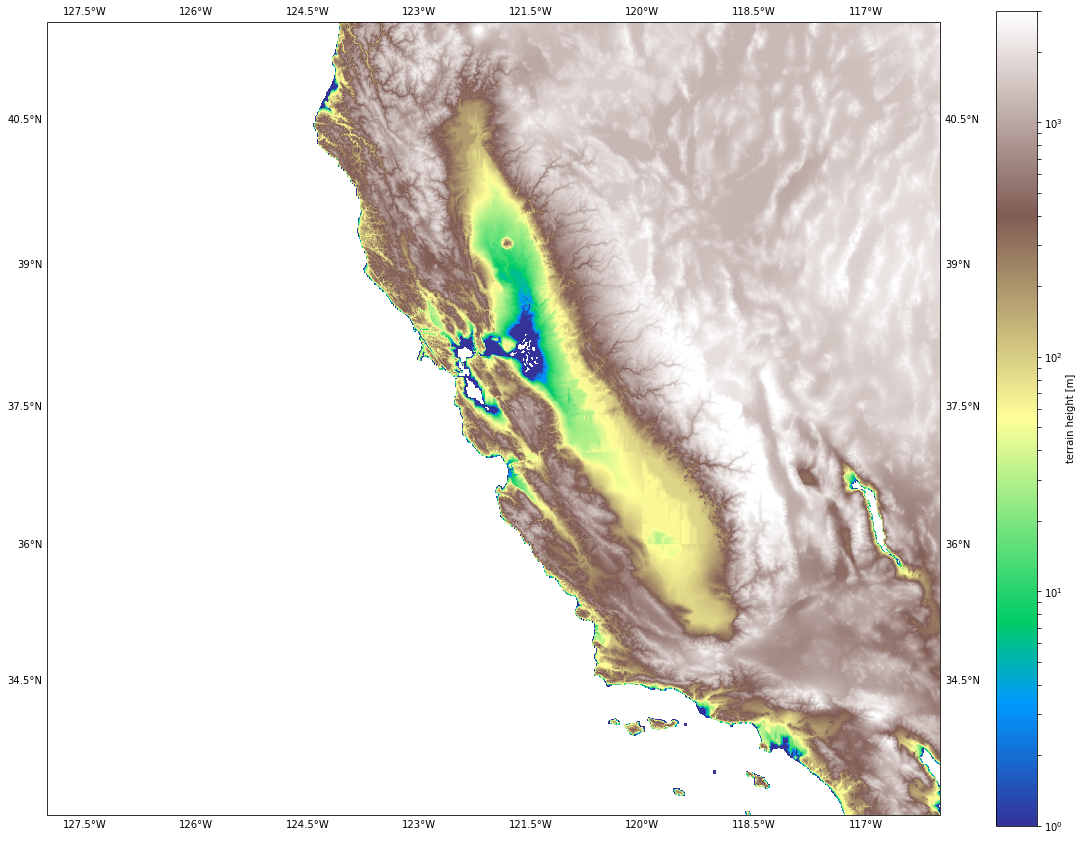

In [24]:
#Set up our figure
fig = plt.figure(figsize = [20,15])

ax = fig.add_subplot(111, projection=map_proj)
ax.gridlines(draw_labels=True,color='None')


# specify kwargs for plotting, using terrain colormap and LogNorm
dem = ax.pcolormesh(rastercoords[..., 0], rastercoords[..., 1],
                    rastervalues, cmap=plt.cm.terrain, norm=LogNorm(),
                    vmin=1, vmax=3000, transform=ccrs.PlateCarree())
# add colorbar and title
# we use LogLocator for colorbar
cb = plt.gcf().colorbar(dem, ticks=ticker.LogLocator(subs=range(10)))
cb.set_label('terrain height [m]')


#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)


# #plot a PPI! add coastline at 10m resolution
# display.plot_ppi_map(
#     'range2d', sweep, colorbar_flag=False,
#     title=title, resolution='50m',
#     projection=projection, 
#     vmin=0, vmax=60,
#     gatefilter = mygf_sea)
# display.plot_ppi_map(
#     'range2d', sweep, colorbar_flag=False,
#     title=title, resolution='50m',
#     projection=projection, 
#     vmin=0, vmax=60, 
#     gatefilter = mygf_land)

ax.set_extent([-128,-116,33,41.5], crs=ccrs.PlateCarree())

plt.setp(ax.get_xticklabels(), fontsize=30)


#plt.savefig('KMUXterrain_01.png',dpi=600)